요구사항1

titanic_dataset.py 분석

In [13]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split


class TitanicDataset(Dataset): #훈련 데이터셋 클래스
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X)
    self.y = torch.LongTensor(y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    feature = self.X[idx]
    target = self.y[idx]
    return {'input': feature, 'target': target}

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str

In [14]:
class TitanicTestDataset(Dataset): #테스트 데이터셋 클래스 훈련 데이터셋과 비교했을때 타겟 데이터가 없음
  def __init__(self, X):
    self.X = torch.FloatTensor(X)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    feature = self.X[idx]
    return {'input': feature}

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}".format(
      len(self.X), self.X.shape
    )
    return str

In [15]:
def get_preprocessed_dataset(): #데이터셋 전처리 함수 
    #CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
    CURRENT_FILE_PATH = os.getcwd() #주피터 노트북에서의 파일경로 오류해결을 위한 수정

    train_data_path = os.path.join(CURRENT_FILE_PATH, "train.csv")
    test_data_path = os.path.join(CURRENT_FILE_PATH, "test.csv")

    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)

    all_df = pd.concat([train_df, test_df], sort=False)

    all_df = get_preprocessed_dataset_1(all_df)

    all_df = get_preprocessed_dataset_2(all_df)

    all_df = get_preprocessed_dataset_3(all_df)

    all_df = get_preprocessed_dataset_4(all_df)

    all_df = get_preprocessed_dataset_5(all_df)

    all_df = get_preprocessed_dataset_6(all_df)
    
    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    train_y = train_df["Survived"]

    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    #훈련 데이터, 타겟 데이터, 테스트 데이터 분리
    dataset = TitanicDataset(train_X.values, train_y.values)
    #print(dataset)
    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2]) #훈련용, 검증용 분리
    test_dataset = TitanicTestDataset(test_X.values)
    #print(test_dataset)

    return train_dataset, validation_dataset, test_dataset

In [16]:
def get_preprocessed_dataset_1(all_df):
    # Pclass별 Fare 평균값을 사용하여 Fare 결측치 메우기
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    Fare_mean.columns = ["Pclass", "Fare_mean"]
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]

    return all_df

In [17]:
def get_preprocessed_dataset_2(all_df):
    # name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    name_df.columns = ["family_name", "honorific", "name"]
    name_df["family_name"] = name_df["family_name"].str.strip()
    name_df["honorific"] = name_df["honorific"].str.strip()
    name_df["name"] = name_df["name"].str.strip()
    all_df = pd.concat([all_df, name_df], axis=1)

    return all_df

In [18]:
def get_preprocessed_dataset_3(all_df):
    # honorific별 Age 평균값을 사용하여 Age 결측치 메우기
    honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").median().round().reset_index()
    honorific_age_mean.columns = ["honorific", "honorific_age_mean", ]
    all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_age_mean"]
    all_df = all_df.drop(["honorific_age_mean"], axis=1)

    return all_df

In [19]:
def get_preprocessed_dataset_4(all_df):
    # 가족수(family_num) 컬럼 새롭게 추가
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

    # 혼자탑승(alone) 컬럼 새롭게 추가
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    all_df["alone"].fillna(0, inplace=True)

    # 학습에 불필요한 컬럼 제거
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

    return all_df

In [20]:
def get_preprocessed_dataset_5(all_df):
    # honorific 값 개수 줄이기
    all_df.loc[
    ~(
            (all_df["honorific"] == "Mr") |
            (all_df["honorific"] == "Miss") |
            (all_df["honorific"] == "Mrs") |
            (all_df["honorific"] == "Master")
    ),
    "honorific"
    ] = "other"
    all_df["Embarked"].fillna("missing", inplace=True)

    return all_df

In [21]:
def get_preprocessed_dataset_6(all_df):
    # 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
    category_features = all_df.columns[all_df.dtypes == "object"]
    from sklearn.preprocessing import LabelEncoder
    for category_feature in category_features:
        le = LabelEncoder()
        if all_df[category_feature].dtypes == "object":
          le = le.fit(all_df[category_feature])
          all_df[category_feature] = le.transform(all_df[category_feature])

    return all_df

In [22]:
from torch import nn
class MyModel(nn.Module):
  def __init__(self, n_input, n_output):
    super().__init__()

    self.model = nn.Sequential(
      nn.Linear(n_input, 30),
      nn.ReLU(),
      nn.Linear(30, 30),
      nn.ReLU(),
      nn.Linear(30, n_output),
    )

  def forward(self, x):
    x = self.model(x)
    return x

In [23]:
def test(test_data_loader):
  print("[TEST]")
  batch = next(iter(test_data_loader))
  print("{0}".format(batch['input'].shape))
  my_model = MyModel(n_input=11, n_output=2)
  output_batch = my_model(batch['input']) #모델 예측
  prediction_batch = torch.argmax(output_batch, dim=1) #예측값중 최대값 추출
  for idx, prediction in enumerate(prediction_batch, start=892):
      print(idx, prediction.item()) #예측결과

In [24]:
if __name__ == "__main__":
  train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

  print("train_dataset: {0}, validation_dataset.shape: {1}, test_dataset: {2}".format(
    len(train_dataset), len(validation_dataset), len(test_dataset)
  ))
  print("#" * 50, 1)

  for idx, sample in enumerate(train_dataset):
    print("{0} - {1}: {2}".format(idx, sample['input'], sample['target']))

  print("#" * 50, 2)

  train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
  validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=16, shuffle=True)
  test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

  print("[TRAIN]")
  for idx, batch in enumerate(train_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("[VALIDATION]")
  for idx, batch in enumerate(validation_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("#" * 50, 3)

  test(test_data_loader)

C:\Users\whdal\AppData\Local\Temp\ipykernel_30940\4164815060.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["alone"].fillna(0, inplace=True)
C:\Users\whdal\AppData\Local\Temp\ipykernel_30940\2801387961.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

train_dataset: 713, validation_dataset.shape: 178, test_dataset: 418
################################################## 1
0 - tensor([ 3.0000,  0.0000, 41.0000,  0.0000,  5.0000, 39.6875,  2.0000, 13.3029,
         3.0000,  5.0000,  0.0000]): 0
1 - tensor([ 3.0000,  1.0000, 37.0000,  2.0000,  0.0000,  7.9250,  2.0000, 13.3029,
         2.0000,  2.0000,  0.0000]): 0
2 - tensor([ 2.0000,  1.0000, 32.5000,  1.0000,  0.0000, 30.0708,  0.0000, 21.1792,
         2.0000,  1.0000,  0.0000]): 0
3 - tensor([ 3.0000,  0.0000, 22.0000,  0.0000,  0.0000,  7.7500,  1.0000, 13.3029,
         1.0000,  0.0000,  1.0000]): 1
4 - tensor([ 3.0000,  1.0000, 29.0000,  0.0000,  0.0000,  9.5000,  2.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0
5 - tensor([  1.0000,   1.0000,  19.0000,   3.0000,   2.0000, 263.0000,   2.0000,
         87.5090,   2.0000,   5.0000,   0.0000]): 0
6 - tensor([ 1.0000,  1.0000, 71.0000,  0.0000,  0.0000, 34.6542,  0.0000, 87.5090,
         2.0000,  0.0000,  1.0000]): 0
7 - te

요구사항 2

titanic 딥러닝 모델 훈련 코드 및 Activation	Function 변경해보기 => titanic_model_wandb.py 생성

In [25]:
import torch
from torch import nn, optim
from torch.utils.data import random_split, DataLoader
from datetime import datetime
import wandb
import argparse
import pandas as pd
import os

# TitanicDataset 클래스 정의
class TitanicDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return {'input': self.X[idx], 'target': self.y[idx]}

# 데이터셋 전처리 함수
def get_preprocessed_dataset():
    CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
    train_data_path = os.path.join(CURRENT_FILE_PATH, "train.csv")
    train_df = pd.read_csv(train_data_path)

    # 특성과 타겟 분리
    X = train_df.drop(columns=['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'])  # 불필요한 열 제거
    y = train_df['Survived']

    # 전처리: 결측값 처리 및 원-핫 인코딩
    X['Age'] = X['Age'].fillna(X['Age'].mean())  # Age 결측치 평균으로 대체
    X['Fare'] = X['Fare'].fillna(X['Fare'].mean())  # Fare 결측치 평균으로 대체
    X = pd.get_dummies(X, columns=['Sex', 'Embarked'], drop_first=True)

    # 모든 열의 데이터 타입을 float으로 변환
    X = X.astype('float32')

    # 훈련 데이터셋과 검증 데이터셋으로 분할
    dataset = TitanicDataset(X.values, y.values)
    train_size = int(0.8 * len(dataset))
    validation_size = len(dataset) - train_size
    train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

    return train_dataset, validation_dataset, X.shape[1]  # X의 입력 feature 수도 반환

In [26]:
class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]),
            #nn.ReLU(),  # 활성화 함수 설정 (주석으로 변경 가능)
            # nn.ELU(),  # ELU 활성화 함수 사용
            # nn.LeakyReLU(),  # Leaky ReLU 활성화 함수 사용
             nn.PReLU(),  # PReLU 활성화 함수 사용
            nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),
            #nn.ReLU(),  # 활성화 함수 설정 (주석으로 변경 가능)
            # nn.ELU(),  # ELU 활성화 함수 사용
            # nn.LeakyReLU(),  # Leaky ReLU 활성화 함수 사용
             nn.PReLU(),  # PReLU 활성화 함수 사용
            nn.Linear(wandb.config.n_hidden_unit_list[1], n_output),
        )

    def forward(self, x):
        return self.model(x)

In [27]:
def get_model_and_optimizer(n_input):
    my_model = MyModel(n_input=n_input, n_output=1)  # 이진 분류이므로 출력 1
    optimizer = optim.SGD(my_model.parameters(), lr=wandb.config.learning_rate)
    return my_model, optimizer

In [28]:
def training_loop(model, optimizer, train_data_loader, validation_data_loader):
    n_epochs = wandb.config.epochs
    loss_fn = nn.BCEWithLogitsLoss()  # 이진 분류 손실 함수
    next_print_epoch = 100

    for epoch in range(1, n_epochs + 1):
        model.train()
        loss_train = 0.0
        num_trains = 0

        for train_batch in train_data_loader:
            input, target = train_batch['input'], train_batch['target'].float().view(-1, 1)
            optimizer.zero_grad()
            output_train = model(input)
            loss = loss_fn(output_train, target)
            loss_train += loss.item()
            num_trains += 1

            loss.backward()
            optimizer.step()

        # Validation 단계
        model.eval()
        loss_validation = 0.0
        num_validations = 0

        with torch.no_grad():
            for validation_batch in validation_data_loader:
                input, target = validation_batch['input'], validation_batch['target'].float().view(-1, 1)
                output_validation = model(input)
                loss = loss_fn(output_validation, target)
                loss_validation += loss.item()
                num_validations += 1

        wandb.log({
            "Epoch": epoch,
            "Training loss": loss_train / num_trains,
            "Validation loss": loss_validation / num_validations
        })

        if epoch >= next_print_epoch:
            print(
                f"Epoch {epoch}, "
                f"Training loss {loss_train / num_trains:.4f}, "
                f"Validation loss {loss_validation / num_validations:.4f}"
            )
            next_print_epoch += 100

In [29]:
def main(args):
    current_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'learning_rate': 1e-3,
        'n_hidden_unit_list': [20, 20],
    }

    wandb.init(
        mode="online" if args.wandb else "disabled",
        project="titanic_model_training",
        notes="Titanic data experiment",
        tags=["titanic"],
        name=current_time_str,
        config=config
    )

    train_dataset, validation_dataset, n_input = get_preprocessed_dataset()  # X의 입력 feature 수도 받기
    model, optimizer = get_model_and_optimizer(n_input)  # 모델과 옵티마이저 가져오기

    train_data_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True)
    validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset))

    training_loop(model, optimizer, train_data_loader, validation_data_loader)

    wandb.finish()

In [30]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--wandb", action=argparse.BooleanOptionalAction, default=True, help="True or False"
    )
    parser.add_argument(
        "-b", "--batch_size", type=int, default=16, help="Batch size (int, default: 16)"
    )
    parser.add_argument(
        "-e", "--epochs", type=int, default=100, help="Number of training epochs (int, default: 100)"
    )

    args = parser.parse_args()
    main(args)

usage: ipykernel_launcher.py [-h] [--wandb | --no-wandb] [-b BATCH_SIZE]
                             [-e EPOCHS]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\whdal\AppData\Roaming\jupyter\runtime\kernel-0e0c5726-5e56-41ac-84fa-d2bf7f037142.json


SystemExit: 2

C:\Users\whdal\anaconda3\envs\link_dl\lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


파이참에서는 정상 작동하나 주피터 노트북 환경에서만 생기는 오류 파이참에서 실행하여 wandb를 이용해 그래프를 얻어냈음

f_my_model_training_with_argparse_wandb.py를 활용하여 타이타닉 데이터를 받을 수 있도록 수정하였다. 이과정에서 Mymodel에서 더 나은 성능을 보여주는 활성화 함수를 찾기 위해 주석과 같이 각각 활성화 함수들을 확인하였고 여기서 ReLU 활성화 함수를 사용하는것으로 결정하였다.

실행결과에서 Training loss Validation loss 두 그래프를 보여주는 url은 다음과 같다 https://wandb.ai/tmdrms4321-flzlek42-/titanic_model_training/runs/51lqja9m

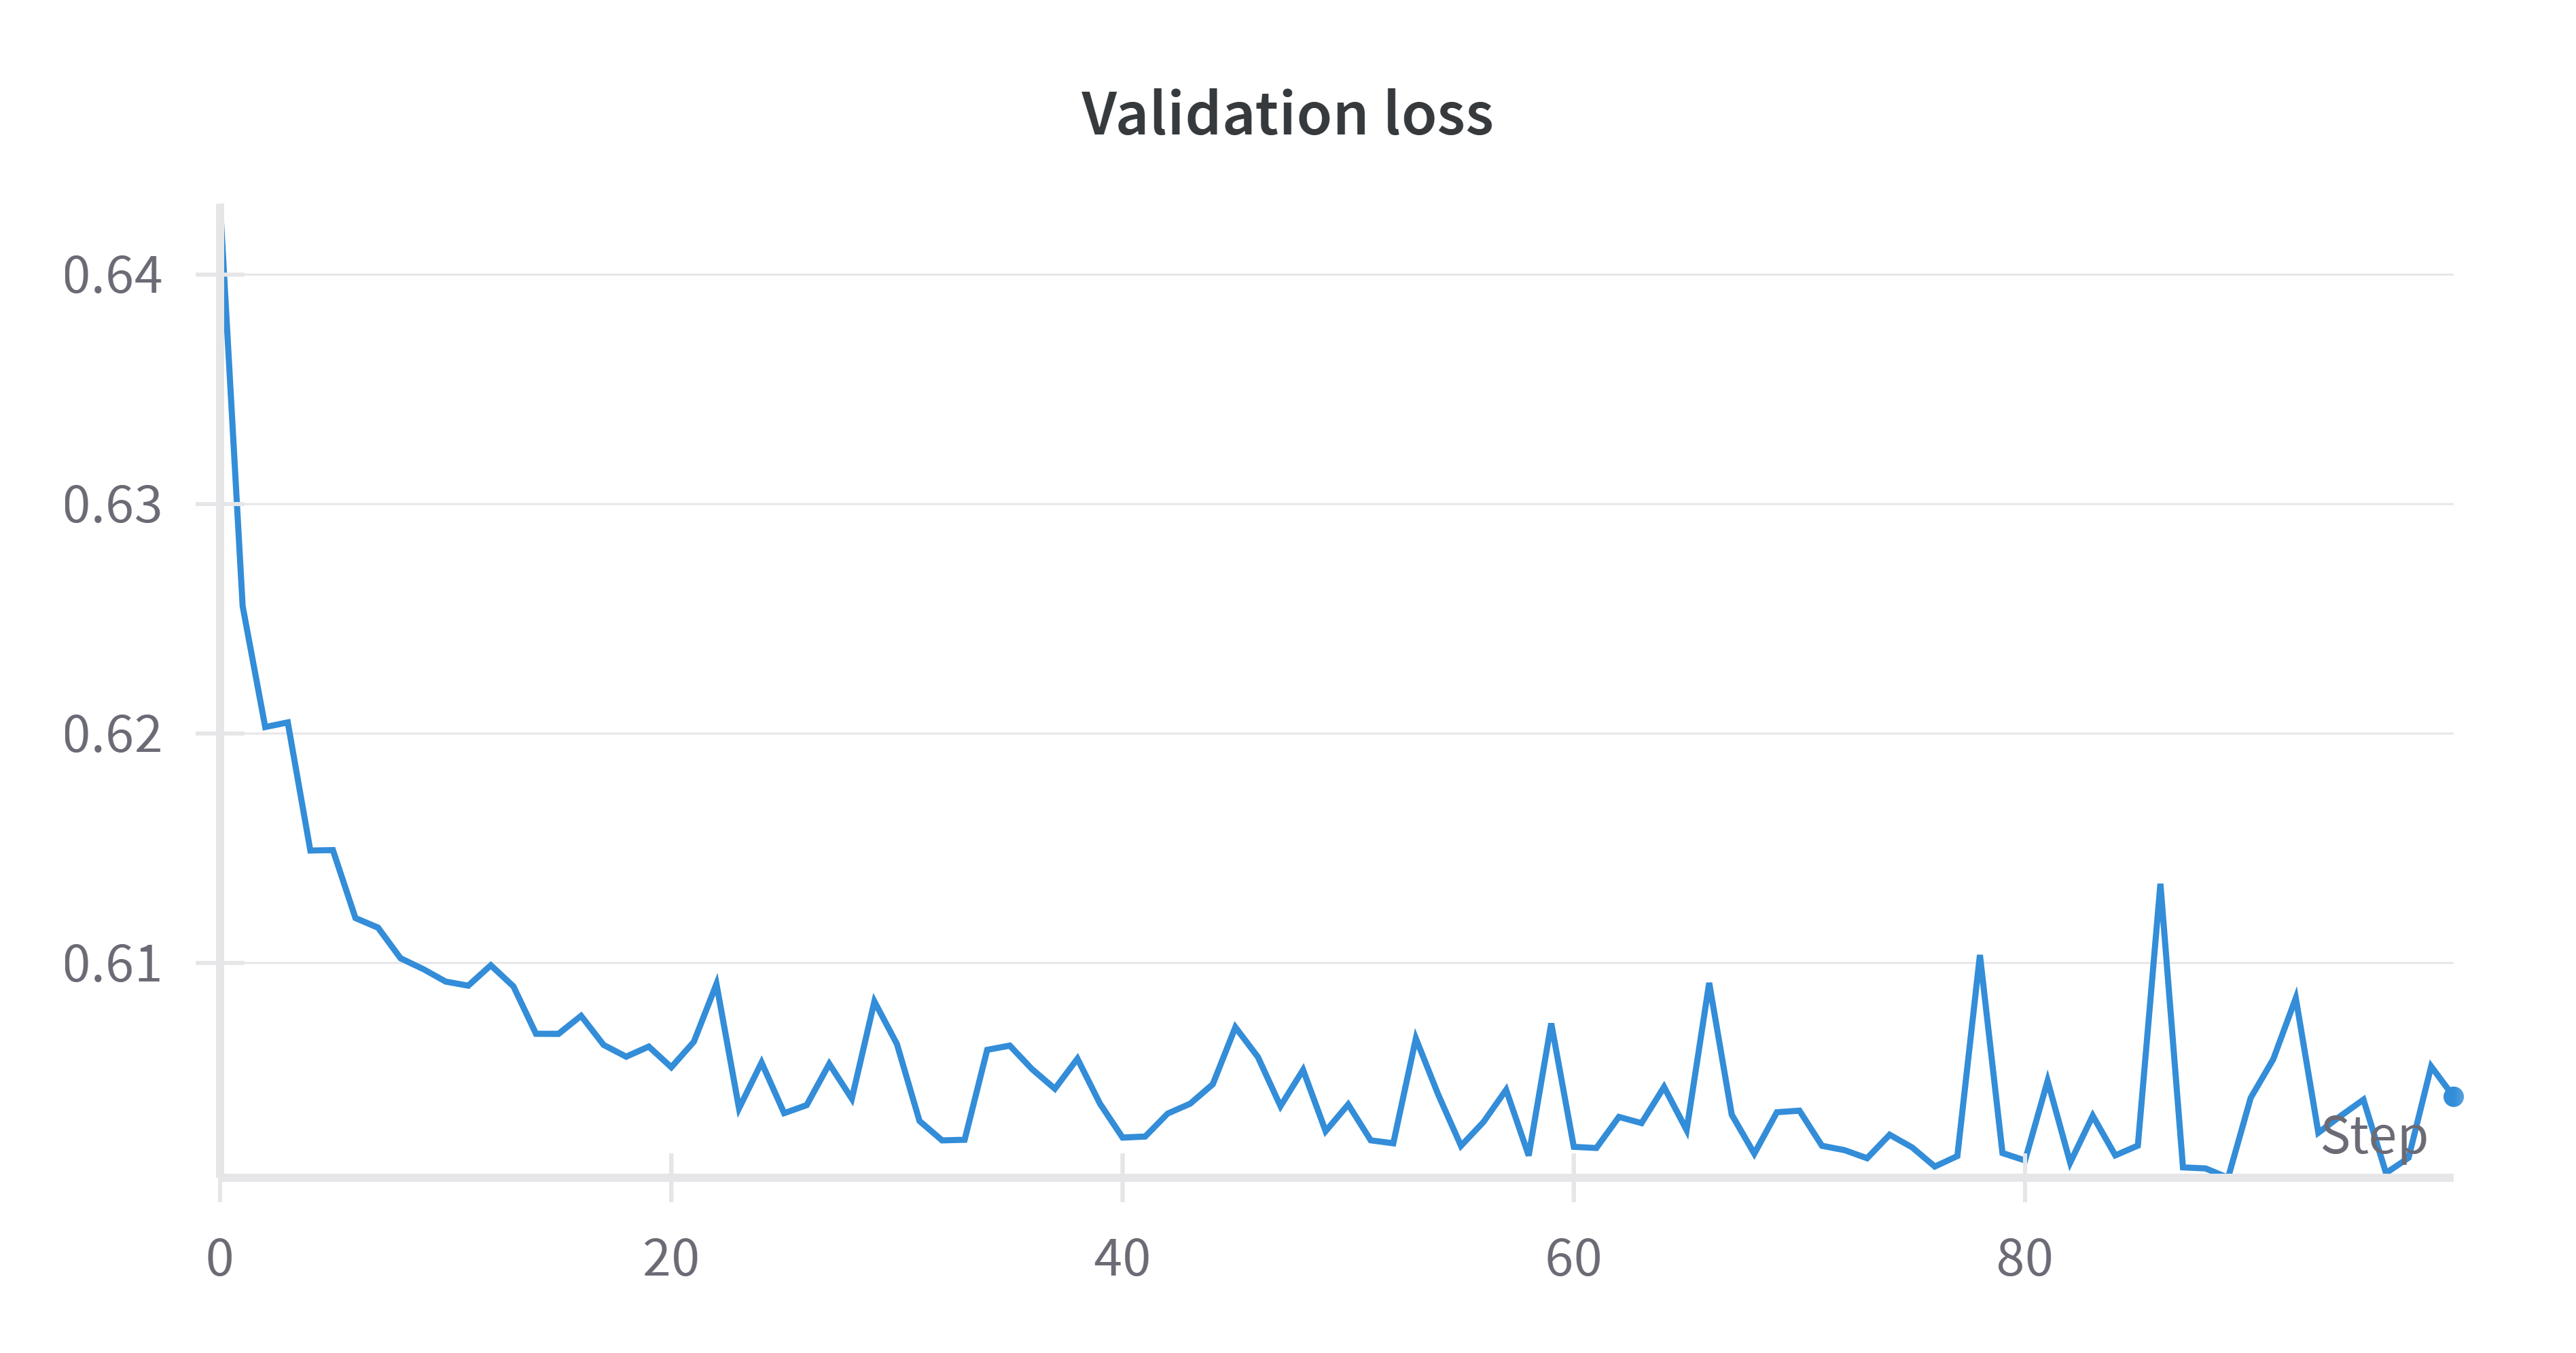

In [31]:
from IPython.display import Image, display

# 이미지 파일 경로 설정
image_path = 'Validation loss.png'  # 다운로드한 이미지 파일 경로

# 이미지 삽입
display(Image(filename=image_path))

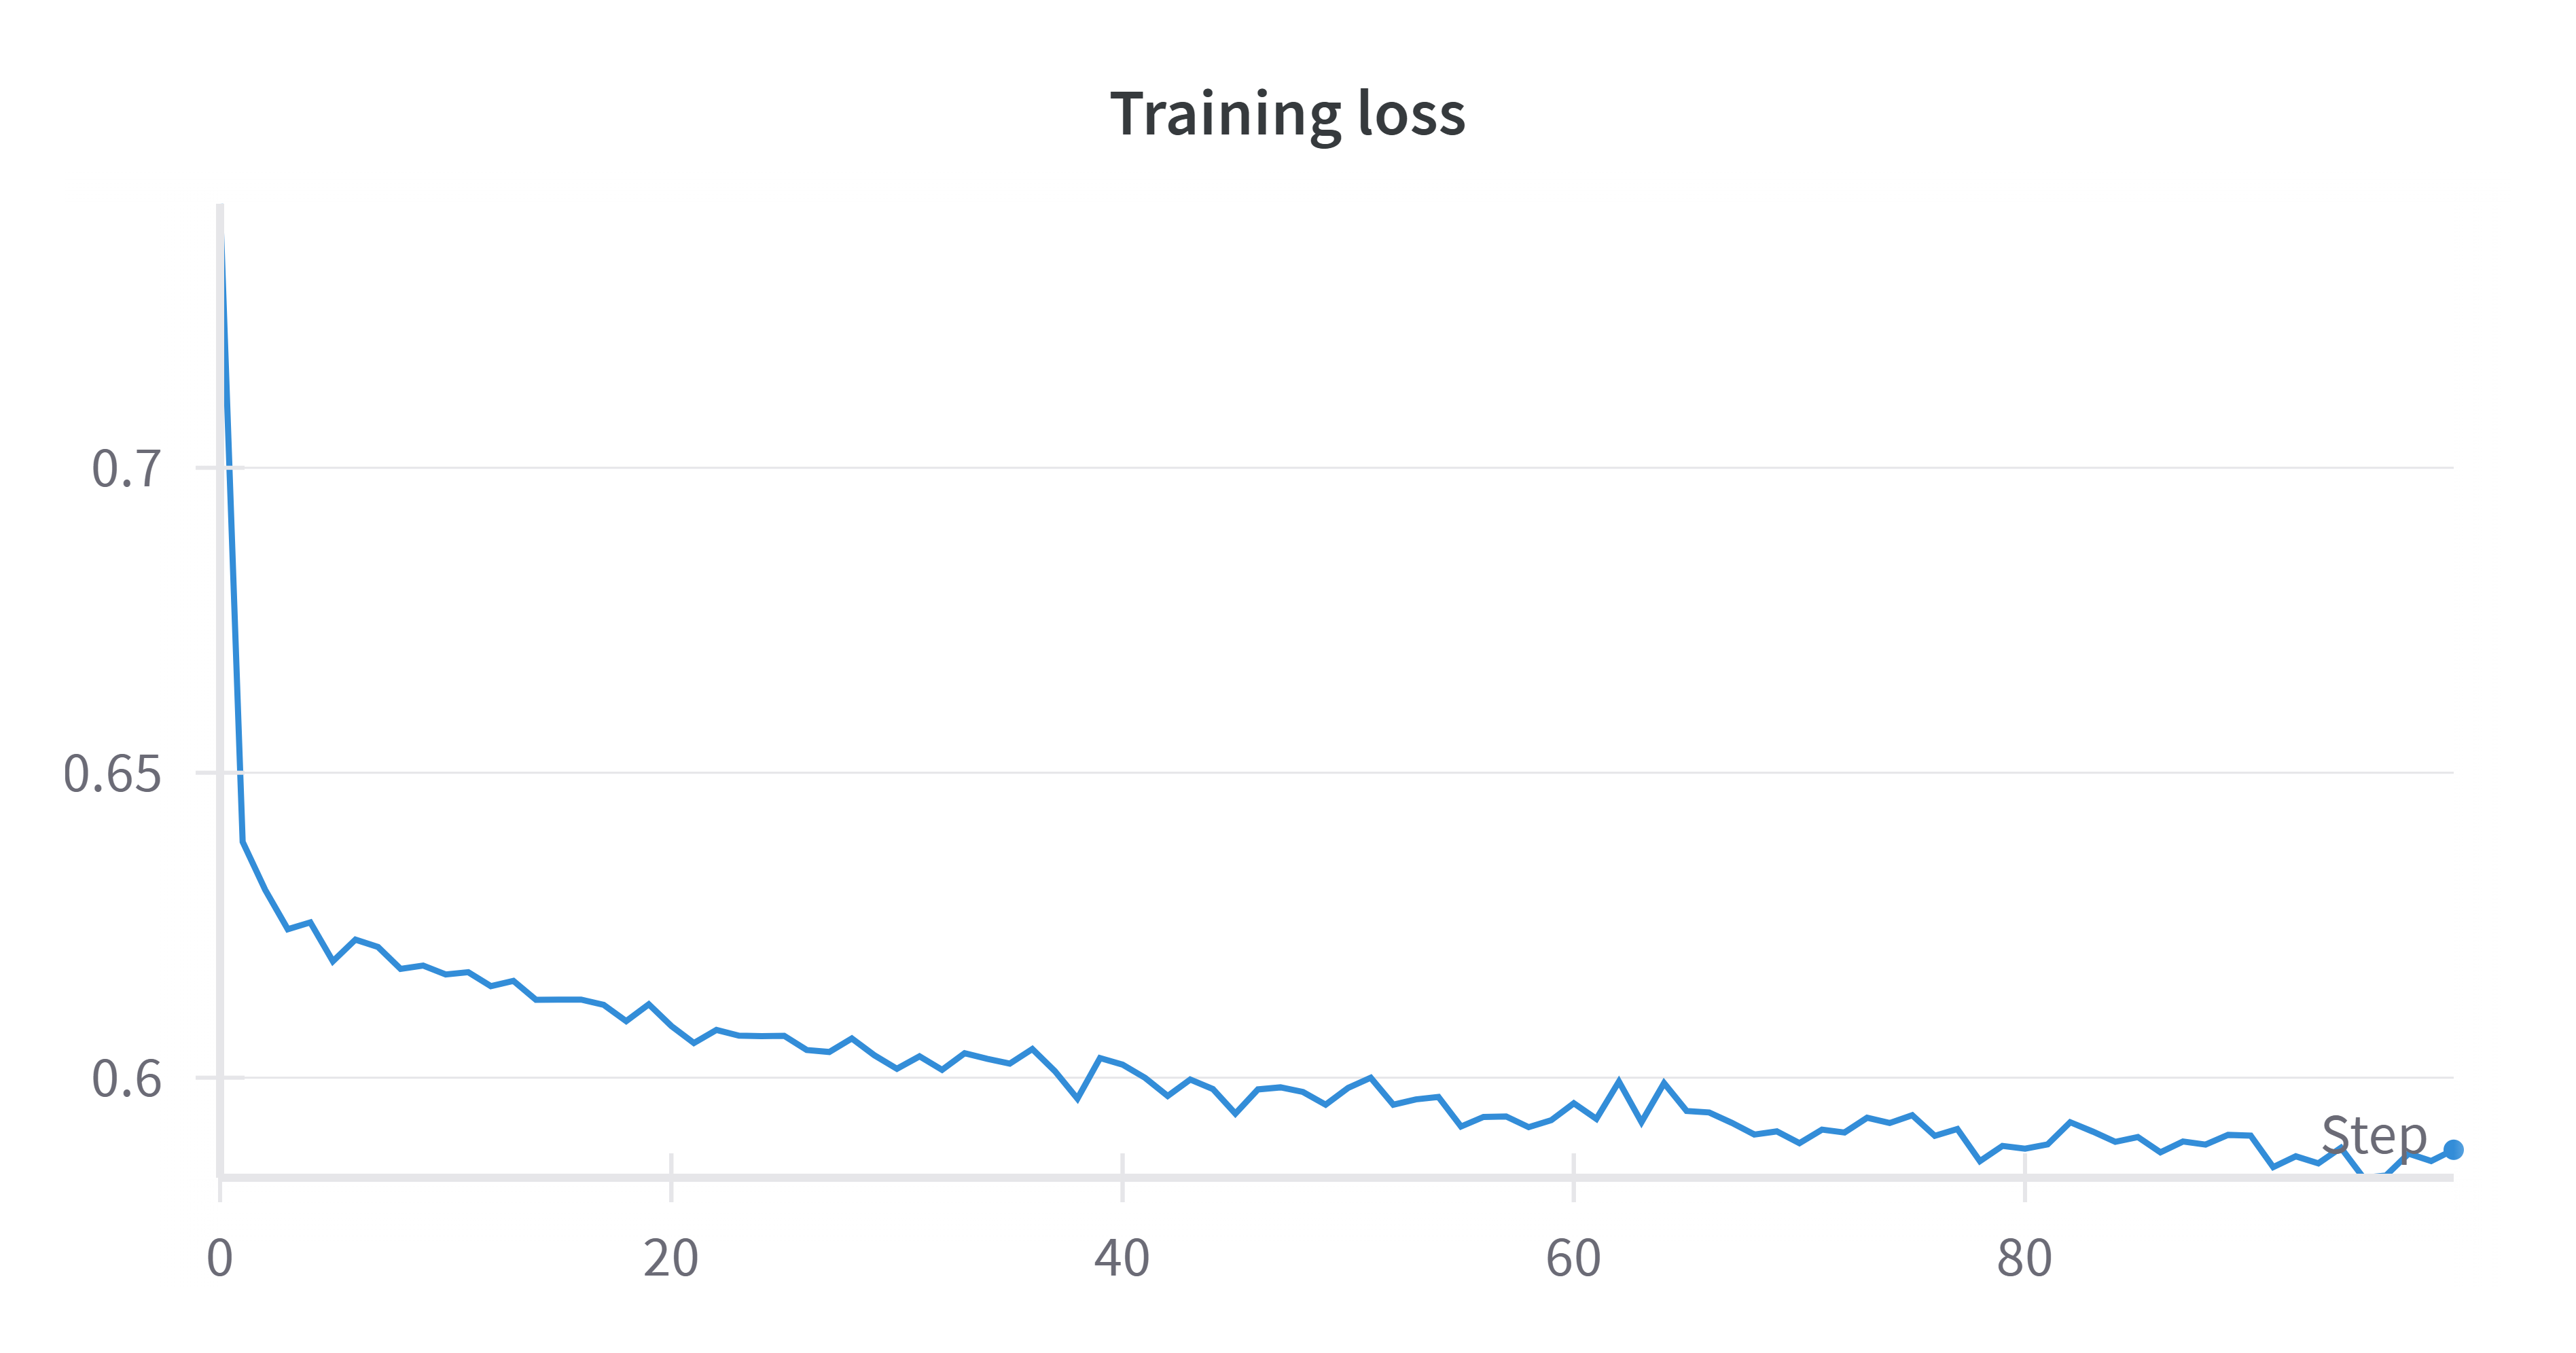

In [32]:
from IPython.display import Image, display

# 이미지 파일 경로 설정
image_path = 'Training loss.png'  # 다운로드한 이미지 파일 경로

# 이미지 삽입
display(Image(filename=image_path))

요구사항 3

어느 Epoch 시점에 테스트를 수행하여 submission.csv 를 구성해야 하는지 생각해보자면 Validation loss가 가장 낮을때가 모델의 성능이 가장 좋다고 볼 수 있다.
그래서 여러 활성화 함수들을 각각 실행시킨 결과를 확인해보았고 그 결과 ReLU 활성화 함수를 사용하는것으로 하였다.
이제 submission.csv을 생성하는 과정을 포함한 최종 코드를 작성하였다.

In [33]:
import torch
from torch import nn, optim
from torch.utils.data import random_split, DataLoader
from datetime import datetime
import wandb
import argparse
import pandas as pd
import os

# TitanicDataset 클래스 정의
class TitanicDataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None):
        self.X = torch.FloatTensor(X)
        if y is not None:  # y가 제공된 경우에만 self.y를 정의 오류방지를 위함
            self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if hasattr(self, 'y'):  # y가 정의되어 있을 때만 반환
            return {'input': self.X[idx], 'target': self.y[idx]}
        else:
            return {'input': self.X[idx]}

In [34]:
# 데이터셋 전처리 함수
def get_preprocessed_dataset():
    CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
    train_data_path = os.path.join(CURRENT_FILE_PATH, "train.csv")
    train_df = pd.read_csv(train_data_path)

    # 특성과 타겟 분리
    X = train_df.drop(columns=['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'])  # 불필요한 열 제거
    y = train_df['Survived'].values  # y 값을 여기서 가져옴

    # 전처리
    X['Age'] = X['Age'].fillna(X['Age'].mean())  # Age 결측치 평균으로 대체
    X['Fare'] = X['Fare'].fillna(X['Fare'].mean())  # Fare 결측치 평균으로 대체
    X = pd.get_dummies(X, columns=['Sex', 'Embarked'], drop_first=True)

    X = X.astype('float32')

    # 훈련 데이터셋과 검증 데이터셋으로 분할
    dataset = TitanicDataset(X.values, y)  # y 값을 포함하여 데이터셋 생성
    train_size = int(0.8 * len(dataset))
    validation_size = len(dataset) - train_size
    train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

    return train_dataset, validation_dataset, X.shape[1], CURRENT_FILE_PATH

In [35]:
class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]),

            nn.ReLU(),# ReLU 활성화 함수 사용
            nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),

            nn.ReLU(),# ReLU 활성화 함수 사용
            nn.Linear(wandb.config.n_hidden_unit_list[1], n_output),
        )

    def forward(self, x):
        return self.model(x)

In [36]:
def get_model_and_optimizer(n_input):
    my_model = MyModel(n_input=n_input, n_output=1)  # 이진 분류이므로 출력 1
    optimizer = optim.SGD(my_model.parameters(), lr=wandb.config.learning_rate)
    return my_model, optimizer

In [37]:
def training_loop(model, optimizer, train_data_loader, validation_data_loader):
    n_epochs = wandb.config.epochs
    loss_fn = nn.BCEWithLogitsLoss()  # 이진 분류 손실 함수
    next_print_epoch = 100

    for epoch in range(1, n_epochs + 1):
        model.train()
        loss_train = 0.0
        num_trains = 0

        for train_batch in train_data_loader:
            input, target = train_batch['input'], train_batch['target'].float().view(-1, 1)
            optimizer.zero_grad()
            output_train = model(input)
            loss = loss_fn(output_train, target)
            loss_train += loss.item()
            num_trains += 1

            loss.backward()
            optimizer.step()

        # Validation 단계
        model.eval()
        loss_validation = 0.0
        num_validations = 0

        with torch.no_grad():
            for validation_batch in validation_data_loader:
                input, target = validation_batch['input'], validation_batch['target'].float().view(-1, 1)
                output_validation = model(input)
                loss = loss_fn(output_validation, target)
                loss_validation += loss.item()
                num_validations += 1

        wandb.log({
            "Epoch": epoch,
            "Training loss": loss_train / num_trains,
            "Validation loss": loss_validation / num_validations
        })

        if epoch >= next_print_epoch:
            print(
                f"Epoch {epoch}, "
                f"Training loss {loss_train / num_trains:.4f}, "
                f"Validation loss {loss_validation / num_validations:.4f}"
            )
            next_print_epoch += 100

In [38]:
def main(args):
    current_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'learning_rate': 1e-3,
        'n_hidden_unit_list': [20, 20],
    }

    wandb.init(
        mode="online" if args.wandb else "disabled",
        project="titanic_model_training",
        notes="Titanic data experiment",
        tags=["titanic"],
        name=current_time_str,
        config=config
    )

    train_dataset, validation_dataset, n_input, CURRENT_FILE_PATH = get_preprocessed_dataset()  # CURRENT_FILE_PATH도 받기
    model, optimizer = get_model_and_optimizer(n_input)  # 모델과 옵티마이저 가져오기

    train_data_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True)
    validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset))

    # 모델 훈련
    training_loop(model, optimizer, train_data_loader, validation_data_loader)

    # 테스트 데이터 로드 및 전처리
    test_data_path = os.path.join(CURRENT_FILE_PATH, "test.csv")
    test_df = pd.read_csv(test_data_path)

    # 테스트 데이터 전처리 (train_df와 동일하게)
    X_test = test_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])  # 불필요한 열 제거
    X_test['Age'] = X_test['Age'].fillna(X_test['Age'].mean())
    X_test['Fare'] = X_test['Fare'].fillna(X_test['Fare'].mean())
    X_test = pd.get_dummies(X_test, columns=['Sex', 'Embarked'], drop_first=True)
    X_test = X_test.astype('float32')

    # 예측 수행
    test_dataset = TitanicDataset(X_test.values)  # X_test는 전처리된 테스트 데이터
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in test_data_loader:
            inputs = batch['input']
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).numpy()  # 확률로 변환
            predictions.extend(preds.flatten())

    # submission.csv 생성
    submission_df = pd.DataFrame({
        'PassengerId': test_df['PassengerId'],
        'Survived': [1 if p >= 0.5 else 0 for p in predictions]
    })
    submission_df.to_csv('submission.csv', index=False)

    wandb.finish()

In [39]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--wandb", action=argparse.BooleanOptionalAction, default=True, help="True or False"
    )
    parser.add_argument(
        "-b", "--batch_size", type=int, default=16, help="Batch size (int, default: 16)"
    )
    parser.add_argument(
        "-e", "--epochs", type=int, default=100, help="Number of training epochs (int, default: 100)"
    )

    args = parser.parse_args()
    main(args)

usage: ipykernel_launcher.py [-h] [--wandb | --no-wandb] [-b BATCH_SIZE]
                             [-e EPOCHS]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\whdal\AppData\Roaming\jupyter\runtime\kernel-0e0c5726-5e56-41ac-84fa-d2bf7f037142.json


SystemExit: 2

요구사항 4

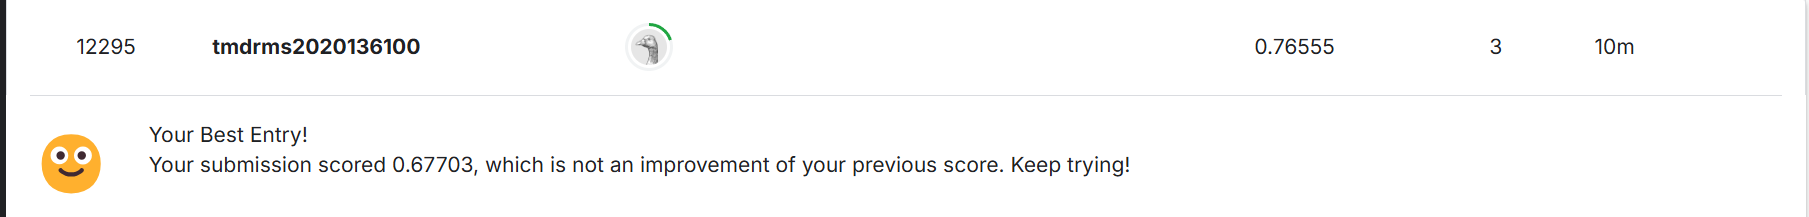

In [40]:
from IPython.display import Image, display

# 이미지 파일 경로 설정
image_path = 'submisson.png'  # 다운로드한 이미지 파일 경로

# 이미지 삽입
display(Image(filename=image_path))

점수가 0.76555 로 나오지만 이것은 기존 파일을 테스트용으로 사용했을때 나온 점수로 실제 내 코드로 나온 파일의 점수는 0.67703이 나왔다.

숙제후기

이번 과제는 그동안 배웠던 이론과 개념으로 우리가 풀어본 예제 코드를 지정된 데이터셋에 맞도록 수정하고 이를 테스트 해야했다. 이전에 비슷한 내용의 예제도 공부했었지만 실제로 해보니 더 어려웠고 이번과제에서 사용하게된 외부 사이트들도 사용법을 모르는 처음에는 사용하기 힘들었다. 하지만 백준처럼 자신의 결과물을 테스트 해보고 등수도 나오다 보니 경쟁심을 얻을 수 있었다. 그래서 어렵지만 열심히 진행할 수 있었고 그 결과 나의 코드로 나온 점수가 기본으로 제공되는 점수에 다다르지 못해서 많이 아쉬웠다. 이후에 더 많은 활성화 함수를 사용해보고 결과적으로 ReLU 활성화 함수를 사용한 후 Leaky ReLU함수를 같이 사용하는 것으로 점수를 0.68660까지 올릴 수 있었다. 아직은 부족하지만 그래도 처음보단 개선된 수치라 다행이라 생각했다.